In [1]:
import numpy as np
import sys,os
from tqdm import tqdm
import time
import random
import datetime
sys.path.append(os.pardir)
from __init__ import *
from NEURON.LIF_CORTEX import LIF_cortex as Cortex
#from NEURON.LIF_STRIATUM import LIF_striatum as Striatum
#from NEURON.LIF_STRIATUM_resonate import LIF_striatum as Striatum
from NEURON.LIF_STRIATUM_resonate_2020_0104 import LIF_striatum as Striatum
from NEURON.LIF_GPe import LIF_gpe as Gpe
from NEURON.LIF_SNr import LIF_snr as Snr

import random
import math
import matplotlib.pyplot as plt

pi = np.pi

class Network:
    def __init__(self, num_ctx, num_str, num_gpe, num_snr, frq_ctx, frq_str, frq_gpe, frq_snr, weight, dop):
        self.numCtx = num_ctx
        self.neuronCtx = [Cortex() for i in range(num_ctx)]
        self.numStr = num_str
        self.neuronStr = [Striatum() for i in range(num_str)]
        self.numGpe = num_gpe
        self.neuronGpe = [Gpe() for i in range(num_gpe)]
        self.numSnr = num_snr
        self.neuronSnr = [Snr() for i in range(num_snr)]
        
        self.frq_ctx =frq_ctx
        self.frq_str =frq_str
        self.frq_gpe =frq_gpe
        self.frq_snr =frq_snr
        
        self.dop = dop #ドーパミンありの時dop=[1,0]、ドーパミンなしの時dop=[0,1]
        self.weight = weight
        self.generate_weights()

    def generate_weights(self): ## w1:ctx-str w2:str-snr w3:str-gpe w4:gpe-snr w5:snr-ctx
        self.w1 = np.zeros((self.numCtx, self.numStr))
        self.w2 = np.zeros((self.numStr, self.numGpe))
        self.w3 = np.zeros((self.numStr, self.numSnr))
        self.w4 = np.zeros((self.numGpe, self.numSnr))
        self.w5 = np.zeros((self.numSnr, self.numCtx))
        for i in range(self.numCtx):
            for j in range(self.numStr):
                self.w1[i,j] = random.choice([0,1])
        for i in range(self.numStr):
            for j in range(self.numSnr):
                self.w2[i,j] = random.choice([0,-1])
        for i in range(self.numStr):
            for j in range(self.numGpe):
                self.w3[i,j] = random.choice([0,-1])
        for i in range(self.numGpe):
            for j in range(self.numSnr):
                self.w4[i,j] = random.choice([0,-1])
        for i in range(self.numSnr):
            for j in range(self.numCtx):
                self.w5[i,j] = random.choice([0,-1])
                

    def fire(self,time):
        time = time
        dt = 1

        firings_Ctx = []
        firings_Str = []
        firings_Gpe = []
        firings_Snr = []
#         threshold = []
        resv = []
        for t in range(time):
            if t < 3000:
                if np.sin(t*2*pi/333) > 0.9:
                    I_Ctx = np.random.normal(1, 0.3, self.numCtx)*self.frq_ctx*0.8 + np.random.normal(1, 1, self.numCtx)*self.frq_ctx*0.2
                else:
                    I_Ctx = np.random.normal(1, 1, self.numCtx)*self.frq_ctx*0.2
            else:
                    I_Ctx = np.random.normal(1, 1, self.numCtx)*self.frq_ctx*0.5
#            I_Ctx = np.random.normal(1, 0.3, self.numCtx) * np.sin(t*2*pi/333)*self.frq_ctx*0.8 + np.random.normal(1, 1, self.numCtx)*self.frq_ctx*0.2
#            I_Ctx = np.random.normal(1, 1, self.numCtx) * (np.sin(t*2*pi/333)*0.5 + 1)*self.frq_ctx*0.75 + np.random.normal(1, 1, self.numCtx)*self.frq_ctx*0.25
#            if t < 5000:
#                I_Ctx = np.random.normal(1, 1, self.numCtx) * (np.sin(t*2*pi/333)*0.5 + 1)*2 + np.random.normal(1, 1, self.numCtx)*2## (sin+1)**2 で 0~4の尖ったinput
#            else:
#                 I_Ctx = np.random.normal(1, 1, self.numCtx)*w ## (sin+1)**2 で 0~4の尖ったinput
            I_Str = np.random.normal(1, 1, self.numStr) * self.frq_str
            I_Gpe = np.random.normal(1, 1, self.numStr) * self.frq_gpe
            I_Snr = np.random.normal(1, 1, self.numStr) * self.frq_snr
            
        
            fired_Ctx = [i for i in range(self.numCtx) if self.neuronCtx[i].v >= self.neuronCtx[i].thrs] #閾値を超えたニューロン番号
#            fired_Str = [i for i in range(self.numStr) if self.neuronStr[i].resv >= self.neuronStr[i].thrs]
            fired_Str = [i for i in range(self.numStr) if self.neuronStr[i].v >= self.neuronStr[i].thrs]
            fired_Gpe = [i for i in range(self.numGpe) if self.neuronGpe[i].v >= self.neuronGpe[i].thrs]
            fired_Snr = [i for i in range(self.numSnr) if self.neuronSnr[i].v >= self.neuronSnr[i].thrs]
            
            len_fired_Ctx = len(fired_Ctx)
            len_fired_Str = len(fired_Str)
            len_fired_Gpe = len(fired_Gpe)
            len_fired_Snr = len(fired_Snr)
            
            len_firings_Ctx = len(firings_Ctx)
            len_firings_Str = len(firings_Str)
            len_firings_Gpe = len(firings_Gpe)
            len_firings_Snr = len(firings_Snr)

            
            if len_fired_Ctx == 0: 
                pass 
            elif len_firings_Ctx == 0:
                firings_Ctx = [[neuronNumber, t] for neuronNumber in fired_Ctx]
            else:
                fire_time_Ctx = [[neuronNumber, t] for neuronNumber in fired_Ctx]
                firings_Ctx = np.concatenate((firings_Ctx, fire_time_Ctx), axis=0) ##[ニューロン番号、時間]を入れていく(n*2の配列)
                
            if len_fired_Str == 0:
                pass 
            elif len_firings_Str == 0:
                firings_Str = [[neuronNumber, t, self.neuronStr[neuronNumber].res_frq] for neuronNumber in fired_Str]
            else:
                fire_time_Str = [[neuronNumber, t, self.neuronStr[neuronNumber].res_frq] for neuronNumber in fired_Str]
                firings_Str = np.concatenate((firings_Str, fire_time_Str), axis=0)
            
            if len_fired_Gpe == 0: 
                pass 
            elif len_firings_Gpe == 0:
                firings_Gpe = [[neuronNumber, t] for neuronNumber in fired_Gpe]
            else:
                fire_time_Gpe = [[neuronNumber, t] for neuronNumber in fired_Gpe]
                firings_Gpe = np.concatenate((firings_Gpe, fire_time_Gpe), axis=0)
            
            if len_fired_Snr == 0: 
                pass 
            elif len_firings_Snr == 0:
                firings_Snr = [[neuronNumber, t] for neuronNumber in fired_Snr]
            else:
                fire_time_Snr = [[neuronNumber, t] for neuronNumber in fired_Snr]
                firings_Snr = np.concatenate((firings_Snr, fire_time_Snr), axis=0)
            
            
                
            # 発火したニューロンに対してUとVを更新
            for k in range(len(fired_Ctx)):
                for i in range(math.ceil(1/dt)):
                    self.neuronCtx[fired_Ctx[k]].step(dt, I_Ctx[fired_Ctx[k]], 1)        
            for k in range(len(fired_Str)):
                for i in range(math.ceil(1/dt)):
                    self.neuronStr[fired_Str[k]].step(dt, I_Str[fired_Str[k]], 1)
            for k in range(len(fired_Gpe)):
                for i in range(math.ceil(1/dt)):
                    self.neuronGpe[fired_Gpe[k]].step(dt, I_Gpe[fired_Gpe[k]], 1)
            for k in range(len(fired_Snr)):
                for i in range(math.ceil(1/dt)):
                    self.neuronSnr[fired_Snr[k]].step(dt, I_Snr[fired_Snr[k]], 1)
                    
                    

            # 発火を状態によるシナプス電流Iと細胞電位Vの更新
            I_Ctx += np.sum(self.w5[fired_Snr, :], axis=0)*self.weight
            I_Str += np.sum(self.w1[fired_Ctx, :], axis=0)*self.weight
            I_Gpe += np.sum(self.w2[fired_Str, :], axis=0)*self.weight*self.dop[0]
            I_Snr += np.sum(self.w3[fired_Str, :], axis=0)*self.weight*self.dop[1]
            I_Snr += np.sum(self.w4[fired_Gpe, :], axis=0)*self.weight
            
            for k in range(self.numCtx):
                for i in range(math.ceil(1/dt)):
                    self.neuronCtx[k].step(dt, I_Ctx[k], 1)       
            for k in range(self.numStr):
                for i in range(math.ceil(1/dt)):
                    self.neuronStr[k].step(dt, I_Str[k], 1)
            for k in range(self.numGpe):
                for i in range(math.ceil(1/dt)):
                    self.neuronGpe[k].step(dt, I_Gpe[k], 1)       
            for k in range(self.numSnr):
                for i in range(math.ceil(1/dt)):
                    self.neuronSnr[k].step(dt, I_Snr[k], 1)
            
            # 線条体(Str)の閾値の振動状態を記録
#             for k in range(self.numStr):
#                 threshold.append([t, self.neuronStr[k].res_frq, self.neuronStr[k].thrsres]) #[時間、振動周波数、閾値]の順に格納 3*numStr行列
            
            # 線条体(Str)の膜電位の振動状態を記録
            for k in range(self.numStr):
#                resv.append([t, self.neuronStr[k].res_frq, self.neuronStr[k].resv, k]) #[時間、振動周波数、膜電位, neuron番号]の順に格納 4*numStr行列
                resv.append([t, self.neuronStr[k].res_frq, self.neuronStr[k].v, k]) #[時間、振動周波数、膜電位, neuron番号]の順に格納 4*numStr行列
        
    
        #リゾナントの周波数ごとに細胞の数を記録
        res = np.zeros(3)
        for k in range(self.numStr):
            if self.neuronStr[k].res_frq == 2:
                res[0] += 1
            elif self.neuronStr[k].res_frq == 3:
                res[1] += 1
            elif self.neuronStr[k].res_frq == 4:
                res[2] += 1
                
#         return firings_Ctx, firings_Str, firings_Gpe, firings_Snr, threshold, res
        return firings_Ctx, firings_Str, firings_Gpe, firings_Snr, resv, res
    

  0%|          | 0/2 [00:00<?, ?it/s]

8


 50%|█████     | 1/2 [00:56<00:56, 56.07s/it]

8


/home/user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:104: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rc

8


/home/user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcPa

8


  0%|          | 0/2 [00:00<?, ?it/s]

8


 50%|█████     | 1/2 [00:54<00:54, 54.24s/it]

8


  0%|          | 0/2 [00:00<?, ?it/s]

8


 50%|█████     | 1/2 [00:55<00:55, 55.99s/it]

8


  0%|          | 0/2 [00:00<?, ?it/s]

8


 50%|█████     | 1/2 [00:54<00:54, 54.19s/it]

8


  0%|          | 0/2 [00:00<?, ?it/s]

8


 50%|█████     | 1/2 [00:54<00:54, 54.10s/it]

8


  0%|          | 0/2 [00:00<?, ?it/s]

8


 50%|█████     | 1/2 [00:56<00:56, 56.05s/it]

8


  0%|          | 0/2 [00:00<?, ?it/s]

8


 50%|█████     | 1/2 [00:54<00:54, 54.12s/it]

8


  0%|          | 0/2 [00:00<?, ?it/s]

8


 50%|█████     | 1/2 [00:54<00:54, 54.44s/it]

8


  0%|          | 0/2 [00:00<?, ?it/s]

8


 50%|█████     | 1/2 [00:55<00:55, 55.87s/it]

8


  0%|          | 0/2 [00:00<?, ?it/s]

8


 50%|█████     | 1/2 [00:54<00:54, 55.00s/it]

8


  0%|          | 0/2 [00:00<?, ?it/s]

8


 50%|█████     | 1/2 [00:54<00:54, 54.77s/it]

8


  0%|          | 0/2 [00:00<?, ?it/s]

8


 50%|█████     | 1/2 [00:56<00:56, 56.42s/it]

8


  0%|          | 0/2 [00:00<?, ?it/s]

8


 50%|█████     | 1/2 [00:54<00:54, 54.19s/it]

8


  0%|          | 0/2 [00:00<?, ?it/s]

8


 50%|█████     | 1/2 [00:55<00:55, 55.22s/it]

8


  0%|          | 0/2 [00:00<?, ?it/s]

8


 50%|█████     | 1/2 [00:56<00:56, 56.77s/it]

8


  0%|          | 0/2 [00:00<?, ?it/s]

8


 50%|█████     | 1/2 [00:55<00:55, 55.18s/it]

8


  0%|          | 0/2 [00:00<?, ?it/s]

8


 50%|█████     | 1/2 [00:54<00:54, 54.20s/it]

8


  0%|          | 0/2 [00:00<?, ?it/s]

8


 50%|█████     | 1/2 [00:54<00:54, 54.25s/it]

8


  0%|          | 0/2 [00:00<?, ?it/s]

8


 50%|█████     | 1/2 [00:53<00:53, 53.39s/it]

8


  0%|          | 0/2 [00:00<?, ?it/s]

8


 50%|█████     | 1/2 [00:52<00:52, 52.88s/it]

8


  0%|          | 0/2 [00:00<?, ?it/s]

8


 50%|█████     | 1/2 [00:54<00:54, 54.58s/it]

8


  0%|          | 0/2 [00:00<?, ?it/s]

8


 50%|█████     | 1/2 [00:53<00:53, 53.41s/it]

8


  0%|          | 0/2 [00:00<?, ?it/s]

8


 50%|█████     | 1/2 [00:53<00:53, 53.27s/it]

8


  0%|          | 0/2 [00:00<?, ?it/s]

8


 50%|█████     | 1/2 [00:54<00:54, 54.10s/it]

8


  0%|          | 0/2 [00:00<?, ?it/s]

8


 50%|█████     | 1/2 [00:53<00:53, 53.26s/it]

8


  0%|          | 0/2 [00:00<?, ?it/s]

8


 50%|█████     | 1/2 [00:52<00:52, 52.83s/it]

8


  0%|          | 0/2 [00:00<?, ?it/s]

8


 50%|█████     | 1/2 [00:54<00:54, 54.94s/it]

8


  0%|          | 0/2 [00:00<?, ?it/s]

8


 50%|█████     | 1/2 [00:53<00:53, 53.21s/it]

8


  0%|          | 0/2 [00:00<?, ?it/s]

8


 50%|█████     | 1/2 [00:53<00:53, 53.91s/it]

8


  0%|          | 0/2 [00:00<?, ?it/s]

8


 50%|█████     | 1/2 [00:55<00:55, 55.10s/it]

8


  0%|          | 0/2 [00:00<?, ?it/s]

8


 50%|█████     | 1/2 [00:53<00:53, 53.34s/it]

8


  0%|          | 0/2 [00:00<?, ?it/s]

8


 50%|█████     | 1/2 [00:53<00:53, 53.96s/it]

8


  0%|          | 0/2 [00:00<?, ?it/s]

8


 50%|█████     | 1/2 [00:54<00:54, 54.60s/it]

8


  0%|          | 0/2 [00:00<?, ?it/s]

8


 50%|█████     | 1/2 [00:53<00:53, 53.23s/it]

8


  0%|          | 0/2 [00:00<?, ?it/s]

8


 50%|█████     | 1/2 [00:53<00:53, 53.09s/it]

8


  0%|          | 0/2 [00:00<?, ?it/s]

8


 50%|█████     | 1/2 [00:53<00:53, 53.45s/it]

8


  0%|          | 0/2 [00:00<?, ?it/s]

8


 50%|█████     | 1/2 [00:53<00:53, 53.03s/it]

8


  0%|          | 0/2 [00:00<?, ?it/s]

8


 50%|█████     | 1/2 [00:52<00:52, 52.16s/it]

8


  0%|          | 0/2 [00:00<?, ?it/s]

8


 50%|█████     | 1/2 [00:53<00:53, 53.19s/it]

8


  0%|          | 0/2 [00:00<?, ?it/s]

8


 50%|█████     | 1/2 [00:52<00:52, 52.91s/it]

8


  0%|          | 0/2 [00:00<?, ?it/s]

8


 50%|█████     | 1/2 [00:52<00:52, 52.21s/it]

8


  0%|          | 0/2 [00:00<?, ?it/s]

8


 50%|█████     | 1/2 [00:54<00:54, 54.17s/it]

8


  0%|          | 0/2 [00:00<?, ?it/s]

8


 50%|█████     | 1/2 [00:52<00:52, 52.20s/it]

8


  0%|          | 0/2 [00:00<?, ?it/s]

8


 50%|█████     | 1/2 [00:52<00:52, 52.34s/it]

8


  0%|          | 0/2 [00:00<?, ?it/s]

8


 50%|█████     | 1/2 [00:53<00:53, 53.20s/it]

8


  0%|          | 0/2 [00:00<?, ?it/s]

8


 50%|█████     | 1/2 [00:53<00:53, 53.49s/it]

8


  0%|          | 0/2 [00:00<?, ?it/s]

8


 50%|█████     | 1/2 [00:52<00:52, 52.57s/it]

8


  0%|          | 0/2 [00:00<?, ?it/s]

8


 50%|█████     | 1/2 [00:54<00:54, 54.44s/it]

8


  0%|          | 0/2 [00:00<?, ?it/s]

8


 50%|█████     | 1/2 [00:52<00:52, 52.64s/it]

8


  0%|          | 0/2 [00:00<?, ?it/s]

8


 50%|█████     | 1/2 [00:52<00:52, 52.56s/it]

8


  0%|          | 0/2 [00:00<?, ?it/s]

8


 50%|█████     | 1/2 [00:54<00:54, 54.80s/it]

8


  0%|          | 0/2 [00:00<?, ?it/s]

8


 50%|█████     | 1/2 [00:52<00:52, 52.72s/it]

8


  0%|          | 0/2 [00:00<?, ?it/s]

8


 50%|█████     | 1/2 [00:52<00:52, 52.69s/it]

8


  0%|          | 0/2 [00:00<?, ?it/s]

10


 50%|█████     | 1/2 [00:56<00:56, 56.10s/it]

10


  0%|          | 0/2 [00:00<?, ?it/s]

10


 50%|█████     | 1/2 [00:54<00:54, 54.36s/it]

10


  0%|          | 0/2 [00:00<?, ?it/s]

10


 50%|█████     | 1/2 [00:54<00:54, 54.18s/it]

10


  0%|          | 0/2 [00:00<?, ?it/s]

10


 50%|█████     | 1/2 [00:55<00:55, 55.92s/it]

10


  0%|          | 0/2 [00:00<?, ?it/s]

10


 50%|█████     | 1/2 [00:53<00:53, 53.20s/it]

10


  0%|          | 0/2 [00:00<?, ?it/s]

10


 50%|█████     | 1/2 [00:54<00:54, 54.42s/it]

10


  0%|          | 0/2 [00:00<?, ?it/s]

10


 50%|█████     | 1/2 [00:55<00:55, 55.36s/it]

10


  0%|          | 0/2 [00:00<?, ?it/s]

10


 50%|█████     | 1/2 [00:54<00:54, 54.13s/it]

10


  0%|          | 0/2 [00:00<?, ?it/s]

10


 50%|█████     | 1/2 [00:54<00:54, 54.48s/it]

10


  0%|          | 0/2 [00:00<?, ?it/s]

10


 50%|█████     | 1/2 [00:56<00:56, 56.45s/it]

10


  0%|          | 0/2 [00:00<?, ?it/s]

10


 50%|█████     | 1/2 [00:54<00:54, 54.67s/it]

10


  0%|          | 0/2 [00:00<?, ?it/s]

10


 50%|█████     | 1/2 [00:55<00:55, 55.73s/it]

10


  0%|          | 0/2 [00:00<?, ?it/s]

10


 50%|█████     | 1/2 [00:57<00:57, 57.81s/it]

10


  0%|          | 0/2 [00:00<?, ?it/s]

10


 50%|█████     | 1/2 [00:54<00:54, 54.60s/it]

10


  0%|          | 0/2 [00:00<?, ?it/s]

10


 50%|█████     | 1/2 [00:53<00:53, 53.47s/it]

10


  0%|          | 0/2 [00:00<?, ?it/s]

10


 50%|█████     | 1/2 [00:58<00:58, 58.58s/it]

10


  0%|          | 0/2 [00:00<?, ?it/s]

10


 50%|█████     | 1/2 [00:54<00:54, 54.75s/it]

10


  0%|          | 0/2 [00:00<?, ?it/s]

10


 50%|█████     | 1/2 [00:53<00:53, 53.60s/it]

10


  0%|          | 0/2 [00:00<?, ?it/s]

10


 50%|█████     | 1/2 [00:54<00:54, 54.57s/it]

10


  0%|          | 0/2 [00:00<?, ?it/s]

10


 50%|█████     | 1/2 [00:53<00:53, 53.55s/it]

10


  0%|          | 0/2 [00:00<?, ?it/s]

10


 50%|█████     | 1/2 [00:53<00:53, 53.43s/it]

10


  0%|          | 0/2 [00:00<?, ?it/s]

10


 50%|█████     | 1/2 [00:54<00:54, 54.79s/it]

10


  0%|          | 0/2 [00:00<?, ?it/s]

10


 50%|█████     | 1/2 [00:53<00:53, 53.31s/it]

10


  0%|          | 0/2 [00:00<?, ?it/s]

10


 50%|█████     | 1/2 [00:53<00:53, 53.31s/it]

10


  0%|          | 0/2 [00:00<?, ?it/s]

10


 50%|█████     | 1/2 [00:54<00:54, 54.97s/it]

10


  0%|          | 0/2 [00:00<?, ?it/s]

10


 50%|█████     | 1/2 [00:53<00:53, 53.38s/it]

10


  0%|          | 0/2 [00:00<?, ?it/s]

10


 50%|█████     | 1/2 [00:51<00:51, 51.96s/it]

10


  0%|          | 0/2 [00:00<?, ?it/s]

10


 50%|█████     | 1/2 [00:54<00:54, 54.83s/it]

10


  0%|          | 0/2 [00:00<?, ?it/s]

10


 50%|█████     | 1/2 [00:53<00:53, 53.60s/it]

10


  0%|          | 0/2 [00:00<?, ?it/s]

10


 50%|█████     | 1/2 [00:53<00:53, 53.60s/it]

10


  0%|          | 0/2 [00:00<?, ?it/s]

10


 50%|█████     | 1/2 [00:54<00:54, 54.99s/it]

10


  0%|          | 0/2 [00:00<?, ?it/s]

10


 50%|█████     | 1/2 [00:53<00:53, 53.70s/it]

10


  0%|          | 0/2 [00:00<?, ?it/s]

10


 50%|█████     | 1/2 [00:53<00:53, 53.74s/it]

10


  0%|          | 0/2 [00:00<?, ?it/s]

10


 50%|█████     | 1/2 [00:53<00:53, 53.62s/it]

10


  0%|          | 0/2 [00:00<?, ?it/s]

10


 50%|█████     | 1/2 [00:53<00:53, 53.76s/it]

10


  0%|          | 0/2 [00:00<?, ?it/s]

10


 50%|█████     | 1/2 [00:53<00:53, 53.73s/it]

10


  0%|          | 0/2 [00:00<?, ?it/s]

10


 50%|█████     | 1/2 [00:51<00:51, 51.81s/it]

10


  0%|          | 0/2 [00:00<?, ?it/s]

10


 50%|█████     | 1/2 [00:52<00:52, 52.77s/it]

10


  0%|          | 0/2 [00:00<?, ?it/s]

10


 50%|█████     | 1/2 [00:52<00:52, 52.89s/it]

10


  0%|          | 0/2 [00:00<?, ?it/s]

10


 50%|█████     | 1/2 [00:53<00:53, 53.67s/it]

10


  0%|          | 0/2 [00:00<?, ?it/s]

10


 50%|█████     | 1/2 [00:52<00:52, 52.93s/it]

10


  0%|          | 0/2 [00:00<?, ?it/s]

10


 50%|█████     | 1/2 [00:51<00:51, 51.27s/it]

10


  0%|          | 0/2 [00:00<?, ?it/s]

10


 50%|█████     | 1/2 [00:54<00:54, 54.08s/it]

10


  0%|          | 0/2 [00:00<?, ?it/s]

10


 50%|█████     | 1/2 [00:51<00:51, 51.28s/it]

10


  0%|          | 0/2 [00:00<?, ?it/s]

10


 50%|█████     | 1/2 [00:52<00:52, 52.95s/it]

10


  0%|          | 0/2 [00:00<?, ?it/s]

10


 50%|█████     | 1/2 [00:53<00:53, 53.97s/it]

10


  0%|          | 0/2 [00:00<?, ?it/s]

10


 50%|█████     | 1/2 [00:53<00:53, 53.24s/it]

10


  0%|          | 0/2 [00:00<?, ?it/s]

10


 50%|█████     | 1/2 [00:53<00:53, 53.35s/it]

10


  0%|          | 0/2 [00:00<?, ?it/s]

10


 50%|█████     | 1/2 [00:54<00:54, 54.29s/it]

10


  0%|          | 0/2 [00:00<?, ?it/s]

10


 50%|█████     | 1/2 [00:51<00:51, 51.42s/it]

10


  0%|          | 0/2 [00:00<?, ?it/s]

10


 50%|█████     | 1/2 [00:53<00:53, 53.37s/it]

10


  0%|          | 0/2 [00:00<?, ?it/s]

10


 50%|█████     | 1/2 [00:52<00:52, 52.73s/it]

10


  0%|          | 0/2 [00:00<?, ?it/s]

10


 50%|█████     | 1/2 [00:58<00:58, 58.58s/it]

10


  0%|          | 0/2 [00:00<?, ?it/s]

10


 50%|█████     | 1/2 [00:51<00:51, 51.53s/it]

10


100%|██████████| 2/2 [14:36<00:00, 438.02s/it]


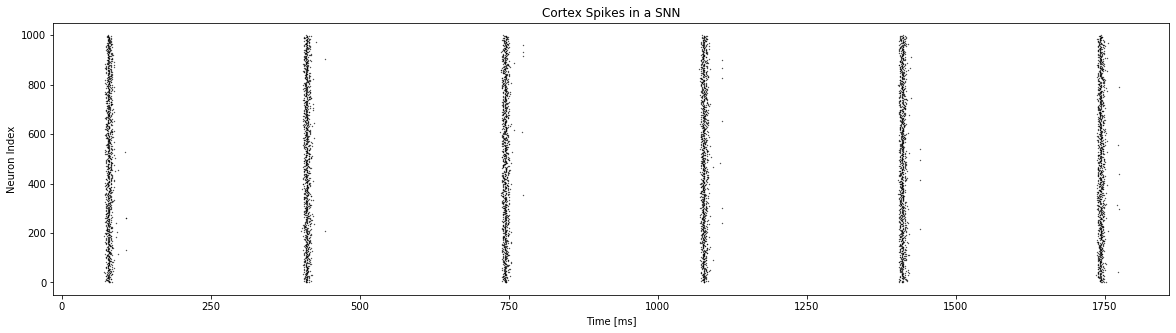

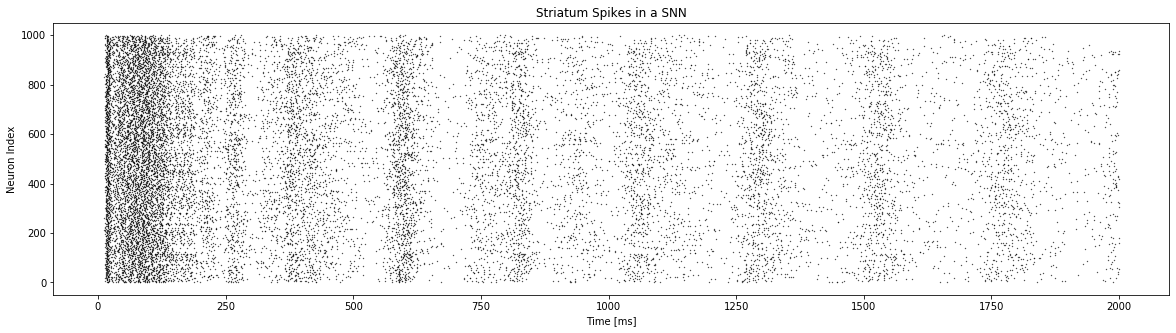

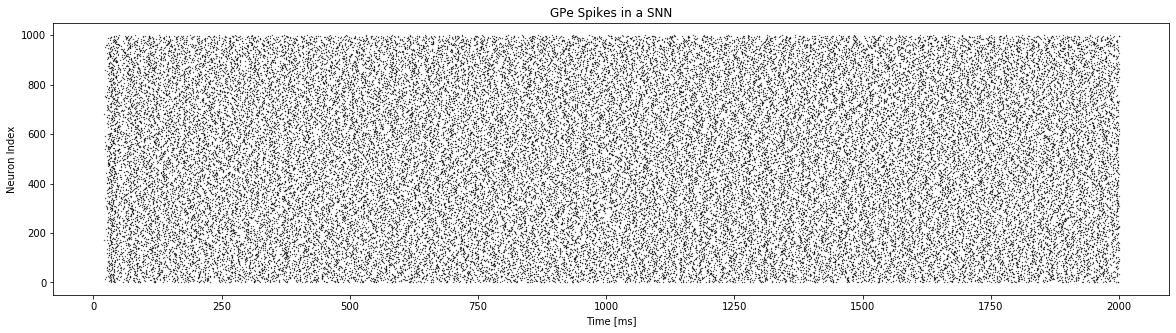

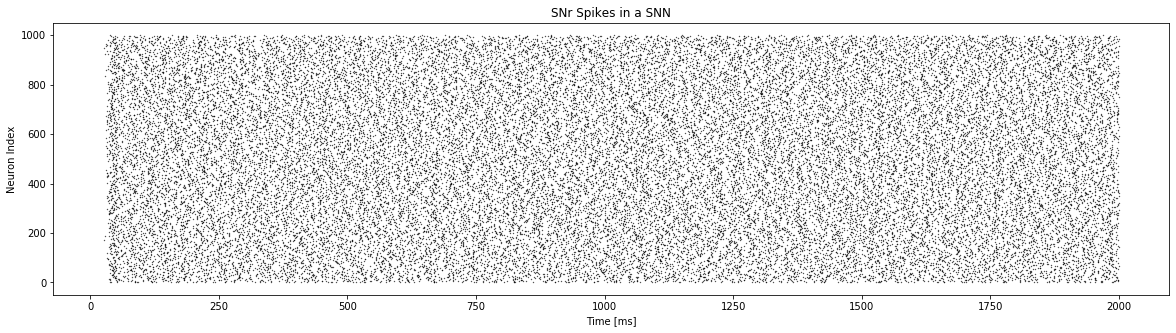

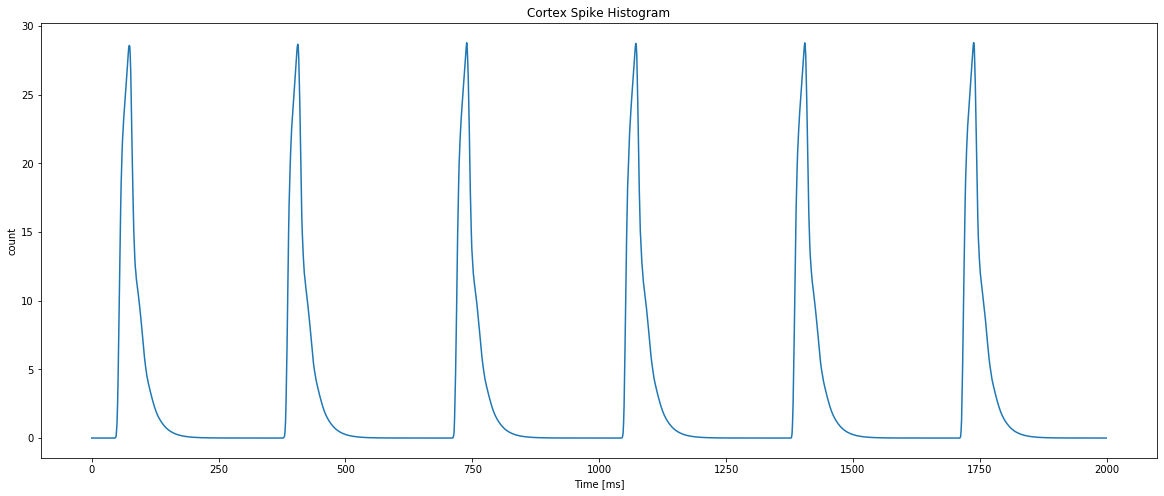

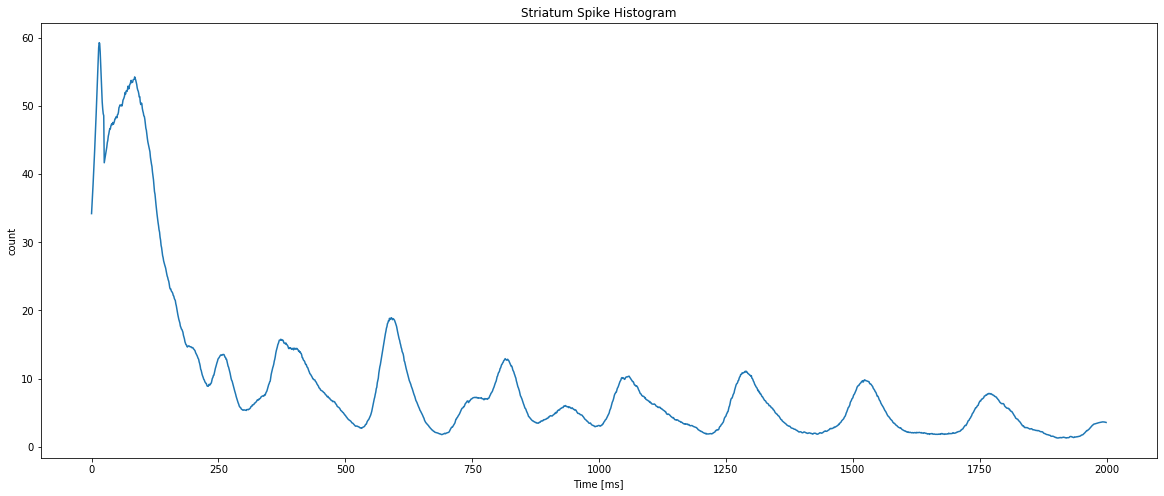

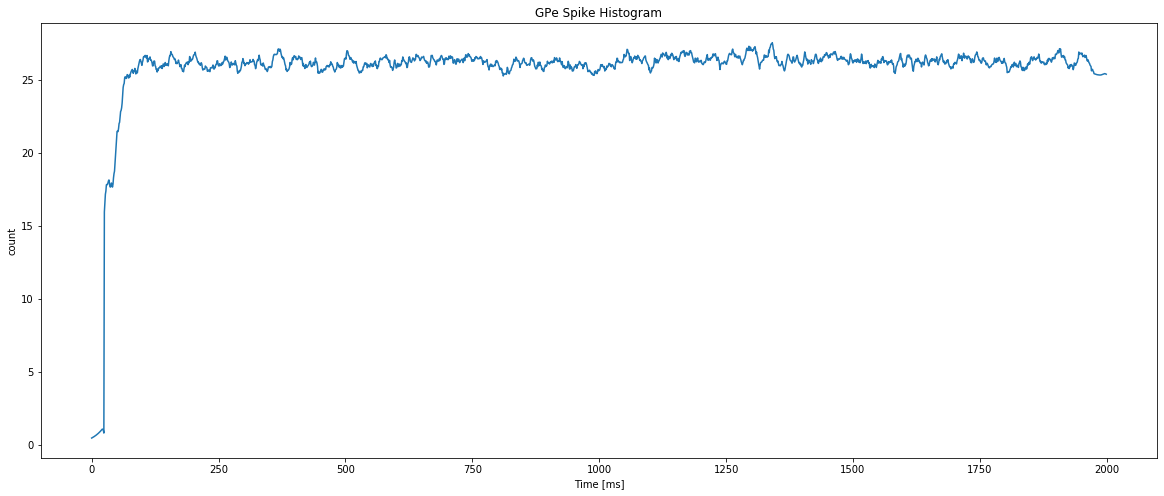

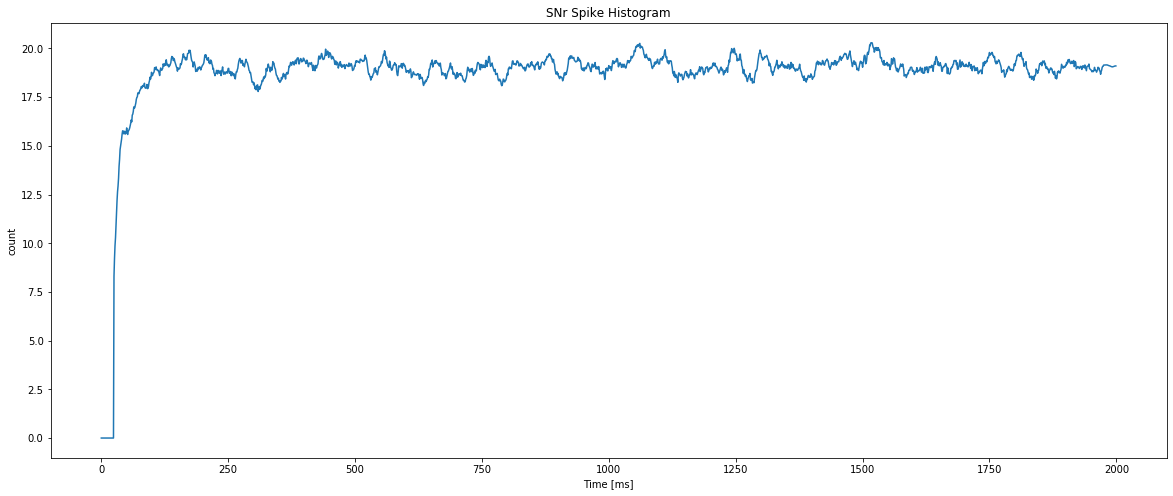

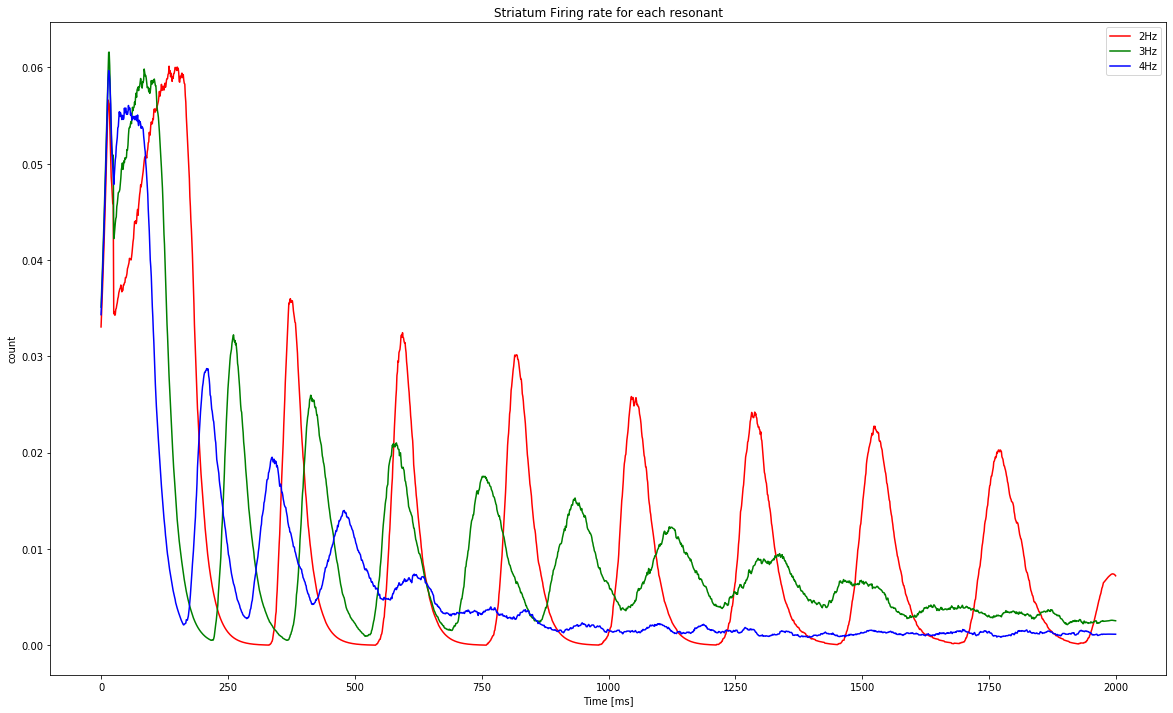

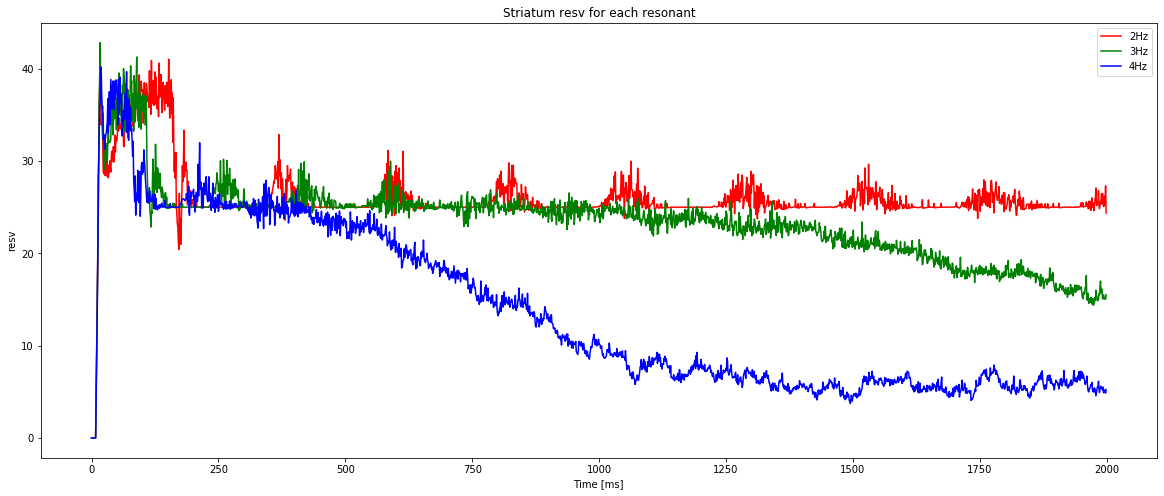

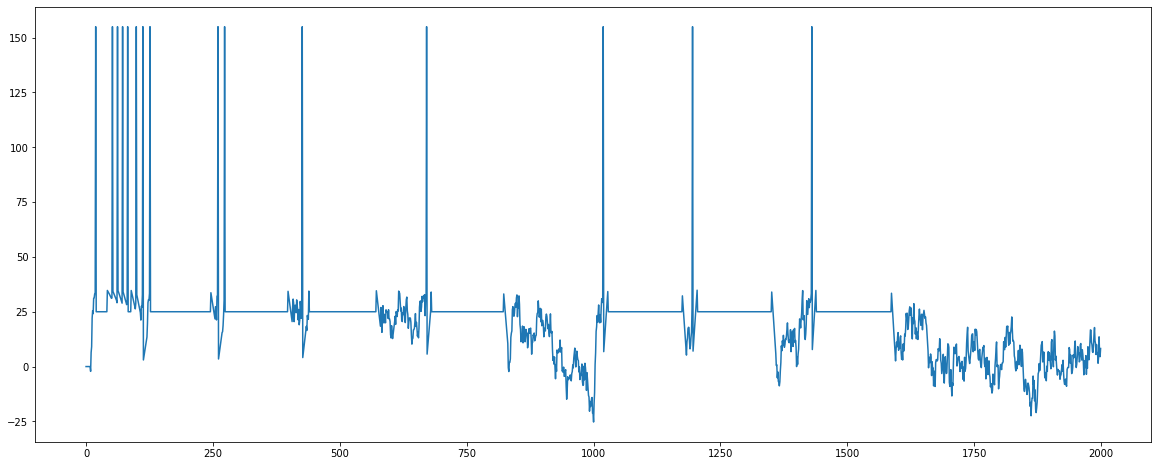

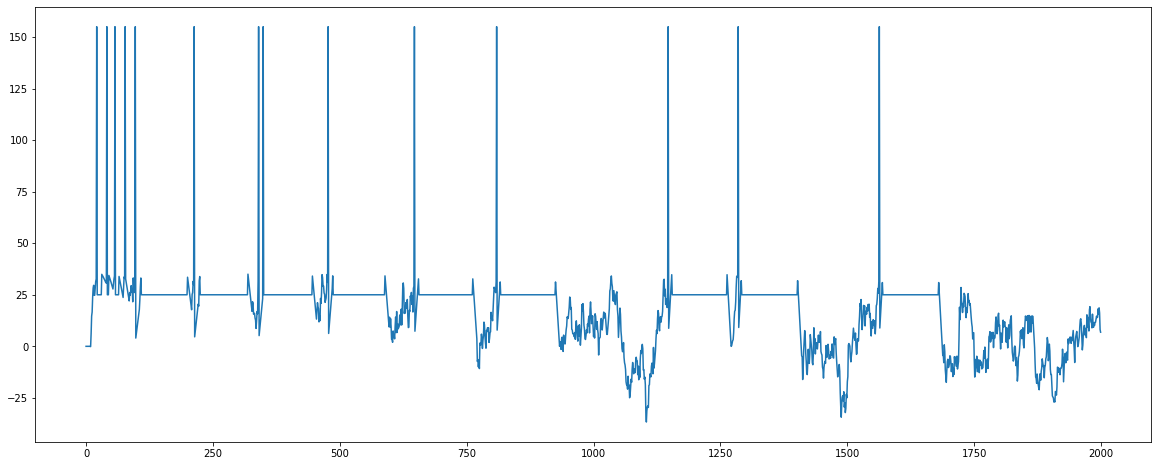

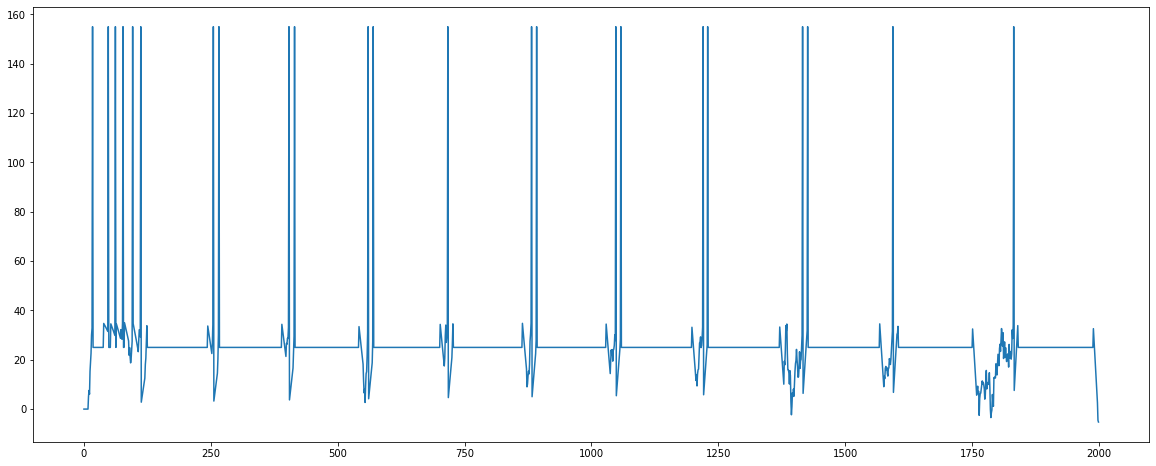

In [ ]:
savepath = '/home/user/Simulation/NETWORK/Figure/'
C = [8,10]
St = [14,16,18]
G = [7,9]
Sn = [6,8,10]
W = [6,10,14]
time = 2000
smooth = 25
dop = [[0,1], [1,0]]

with open('LIF_log','a') as log:
    prompt = '\n\n'+'#'+str(datetime.datetime.now())+'\n'+'LIF_STRIATUM_resonate_2020_0104'+'\n'
    log.write(prompt)
    setting = 'Time'+str(time)+'\n'+'Ctx'+str(C)+' / Str'+str(St)+' / GPe'+str(G)+' / SNr'+str(Sn)+'\n'+'Weight'+str(W)+'\n'
    log.write(setting)
    
for j in C: ##Ctx
    for k in St: #Str
        for l in G: #GPe
            for m in Sn: #SNr
                for w in W: #weight
                    for d in tqdm(range(2)):
                
                        n = Network(1000, 1000, 1000, 1000, j, int(k), l, m, int(w/10), dop[d])## (ニューロン数*4、 発火率*4、 結合重み、ドーパミンON/OFF) の順
                        firings_Ctx, firings_Str, firings_Gpe, firings_Snr, v, res = n.fire(time)
                        print(j)

                        y1 = [firings_Ctx[i][0] for i in range(len(firings_Ctx))]  # neurons
                        x1 = [firings_Ctx[i][1] for i in range(len(firings_Ctx))]  # time 
                        y2 = [firings_Str[i][0] for i in range(len(firings_Str))] 
                        x2 = [firings_Str[i][1] for i in range(len(firings_Str))]
                        y3 = [firings_Gpe[i][0] for i in range(len(firings_Gpe))]
                        x3 = [firings_Gpe[i][1] for i in range(len(firings_Gpe))]
                        y4 = [firings_Snr[i][0] for i in range(len(firings_Snr))]
                        x4 = [firings_Snr[i][1] for i in range(len(firings_Snr))]
                        z = [firings_Str[i][2] for i in range(len(firings_Str))]

                        plt.figure(figsize=(20,5))
                        plt.title("Cortex Spikes in a SNN")
                        plt.ylabel("Neuron Index")
                        plt.xlabel("Time [ms]")
                        plt.scatter(x1, y1, s=0.1, color='black')
                        plt.savefig(savepath+"ctx"+str(j)+"_str"+str(k)+"_gpe"+str(l)+"_snr"+str(m)+"_w"+str(w)+"_dop"+str(d)+"_fig01.png")

                        plt.figure(figsize=(20,5))
                        plt.title("Striatum Spikes in a SNN")
                        plt.ylabel("Neuron Index")
                        plt.xlabel("Time [ms]")
                        plt.scatter(x2, y2, s=0.1, color='black')
                        plt.savefig(savepath+"ctx"+str(j)+"_str"+str(k)+"_gpe"+str(l)+"_snr"+str(m)+"_w"+str(w)+"_dop"+str(d)+"_fig02.png")

                        plt.figure(figsize=(20,5))
                        plt.title("GPe Spikes in a SNN")
                        plt.ylabel("Neuron Index")
                        plt.xlabel("Time [ms]")
                        plt.scatter(x3, y3, s=0.1, color='black')
                        plt.savefig(savepath+"ctx"+str(j)+"_str"+str(k)+"_gpe"+str(l)+"_snr"+str(m)+"_w"+str(w)+"_dop"+str(d)+"_fig03.png")

                        plt.figure(figsize=(20,5))
                        plt.title("SNr Spikes in a SNN")
                        plt.ylabel("Neuron Index")
                        plt.xlabel("Time [ms]")
                        plt.scatter(x4, y4, s=0.1, color='black')
                        plt.savefig(savepath+"ctx"+str(j)+"_str"+str(k)+"_gpe"+str(l)+"_snr"+str(m)+"_w"+str(w)+"_dop"+str(d)+"_fig04.png")
                        
                        


                        plt.figure(figsize = (20,8))
                        plt.title("Cortex Spike Histogram")
                        plt.ylabel("count")
                        plt.xlabel("Time [ms]")
                        smooth = 25
                        x = np.arange(time)
                        y = np.zeros(time)
                        for i in range(len(x1)):
                            y[int(x1[i])] += 1
                        for i in range(smooth):
                            y[i] = np.mean(y[:smooth])
                            y[time-1-i] = np.mean(y[time-smooth:])
                        for i in range(time-smooth):
                            y[i+smooth] = np.mean(y[i:i+smooth*2])
                        plt.plot(x,y)
                        plt.savefig(savepath+"ctx"+str(j)+"_str"+str(k)+"_gpe"+str(l)+"_snr"+str(m)+"_w"+str(w)+"_dop"+str(d)+"_fig05.png")


                        plt.figure(figsize=(20,8))
                        plt.title("Striatum Spike Histogram")
                        plt.ylabel("count")
                        plt.xlabel("Time [ms]")
                        x = np.arange(time)
                        y = np.zeros(time)
                        for i in range(len(x2)):
                            y[int(x2[i])] += 1
                        for i in range(smooth):
                            y[i] = np.mean(y[:smooth])
                            y[time-1-i] = np.mean(y[time-smooth:])
                        for i in range(time-smooth):
                            y[i+smooth] = np.mean(y[i:i+smooth*2])
                        plt.plot(x,y)
                        plt.savefig(savepath+"ctx"+str(j)+"_str"+str(k)+"_gpe"+str(l)+"_snr"+str(m)+"_w"+str(w)+"_dop"+str(d)+"_fig06.png")


                        plt.figure(figsize = (20,8))
                        plt.title("GPe Spike Histogram")
                        plt.ylabel("count")
                        plt.xlabel("Time [ms]")
                        smooth = 25
                        x = np.arange(time)
                        y = np.zeros(time)
                        for i in range(len(x3)):
                            y[int(x3[i])] += 1
                        for i in range(smooth):
                            y[i] = np.mean(y[:smooth])
                            y[time-1-i] = np.mean(y[time-smooth:])
                        for i in range(time-smooth):
                            y[i+smooth] = np.mean(y[i:i+smooth*2])
                        plt.plot(x,y)
                        plt.savefig(savepath+"ctx"+str(j)+"_str"+str(k)+"_gpe"+str(l)+"_snr"+str(m)+"_w"+str(w)+"_dop"+str(d)+"_fig07.png")


                        plt.figure(figsize=(20,8))
                        plt.title("SNr Spike Histogram")
                        plt.ylabel("count")
                        plt.xlabel("Time [ms]")
                        x = np.arange(time)
                        y = np.zeros(time)
                        for i in range(len(x4)):
                            y[int(x4[i])] += 1
                        for i in range(smooth):
                            y[i] = np.mean(y[:smooth])
                            y[time-1-i] = np.mean(y[time-smooth:])
                        for i in range(time-smooth):
                            y[i+smooth] = np.mean(y[i:i+smooth*2])
                        plt.plot(x,y)
                        plt.savefig(savepath+"ctx"+str(j)+"_str"+str(k)+"_gpe"+str(l)+"_snr"+str(m)+"_w"+str(w)+"_dop"+str(d)+"_fig08.png")





                        plt.figure(figsize=(20,12))
                        plt.title("Striatum Firing rate for each resonant")
                        plt.ylabel("count")
                        plt.xlabel("Time [ms]")
                        x = np.arange(time)
                        y2 = np.zeros(time)
                        y3 = np.zeros(time)
                        y4 = np.zeros(time)
                        for i in range(len(z)):
                            if z[i]==2:
                                y2[int(x2[i])] += 1
                            elif z[i]==3:
                                y3[int(x2[i])] += 1
                            elif z[i]==4:
                                y4[int(x2[i])] += 1
                        for i in range(smooth):
                            y2[i] = np.mean(y2[:smooth])
                            y2[time-1-i] = np.mean(y2[time-smooth:])
                            y3[i] = np.mean(y3[:smooth])
                            y3[time-1-i] = np.mean(y3[time-smooth:])
                            y4[i] = np.mean(y4[:smooth])
                            y4[time-1-i] = np.mean(y4[time-smooth:])
                        for i in range(time-smooth):
                            y2[i+smooth] = np.mean(y2[i:i+smooth*2])
                            y3[i+smooth] = np.mean(y3[i:i+smooth*2])
                            y4[i+smooth] = np.mean(y4[i:i+smooth*2])
                        y2 = y2/res[0]
                        y3 = y3/res[1]
                        y4 = y4/res[2]
                        plt.plot(x,y2, color="r",label="2Hz")
                        plt.plot(x,y3, color="g",label="3Hz")
                        plt.plot(x,y4, color="b",label="4Hz")
                        plt.legend()
                        plt.savefig(savepath+"ctx"+str(j)+"_str"+str(k)+"_gpe"+str(l)+"_snr"+str(m)+"_w"+str(w)+"_dop"+str(d)+"_fig09.png")



#                         plt.figure(figsize=(20,8))
#                         plt.title("Striatum threshold for each resonant")
#                         plt.ylabel("threshold")
#                         plt.xlabel("Time [ms]")
#                         x = np.arange(time)
#                         y2 = np.zeros(time)
#                         y3 = np.zeros(time)
#                         y4 = np.zeros(time)
#                         count2 = 0
#                         count3 = 0
#                         count4 = 0
#                         for i in range(len(th)):
#                             if th[i][1]==2:
#                                 y2[int(th[i][0])] += th[i][2]
#                                 count2 += 1
#                             elif th[i][1]==3:
#                                 y3[int(th[i][0])] += th[i][2]
#                                 count3 += 1
#                             elif th[i][1]==4:
#                                 y4[int(th[i][0])] += th[i][2]
#                                 count4 += 1
#                         y2 = y2/res[0]
#                         y3 = y3/res[1]
#                         y4 = y4/res[2]
#                         plt.plot(x,y2, color="r",label="2Hz")
#                         plt.plot(x,y3, color="g",label="3Hz")
#                         plt.plot(x,y4, color="b",label="4Hz")
#                         plt.legend()
#                         plt.savefig(savepath+"ctx"+str(j)+"_str"+str(k)+"_gpe"+str(l)+"_snr"+str(m)+"_w"+str(w)+"_dop"+str(d)+"_fig10.png")

                        plt.figure(figsize=(20,8))
                        plt.title("Striatum resv for each resonant")
                        plt.ylabel("resv")
                        plt.xlabel("Time [ms]")
                        x = np.arange(time)
                        y2 = np.zeros(time)
                        y3 = np.zeros(time)
                        y4 = np.zeros(time)
                        count2 = 0
                        count3 = 0
                        count4 = 0
                        for i in range(len(v)):
                            if v[i][1]==2:
                                y2[int(v[i][0])] += v[i][2]
                                count2 += 1
                            elif v[i][1]==3:
                                y3[int(v[i][0])] += v[i][2]
                                count3 += 1
                            elif v[i][1]==4:
                                y4[int(v[i][0])] += v[i][2]
                                count4 += 1
                        y2 = y2/res[0]
                        y3 = y3/res[1]
                        y4 = y4/res[2]
                        plt.plot(x,y2, color="r",label="2Hz")
                        plt.plot(x,y3, color="g",label="3Hz")
                        plt.plot(x,y4, color="b",label="4Hz")
                        plt.legend()
                        plt.savefig(savepath+"ctx"+str(j)+"_str"+str(k)+"_gpe"+str(l)+"_snr"+str(m)+"_w"+str(w)+"_dop"+str(d)+"_fig11.png")
                        
                        
                        
                        ##each neuron's resv
                        for i in [1,10,100,400,800]:
                            plt.figure(figsize=(20,8))
                            x = np.arange(time)
                            y = np.zeros(time)
                            for a in range(len(v)):
                                if v[a][3]==i:
                                    y[int(v[a][0])] = v[a][2]
                            plt.plot(x,y,label="Neuron"+str(i))
                            plt.savefig(savepath+"ctx"+str(j)+"_str"+str(k)+"_gpe"+str(l)+"_snr"+str(m)+"_w"+str(w)+"_dop"+str(d)+"_fig12_"+str(i)+".png")